1. Подготовка данных


In [490]:
# Импорт библиотек
import pandas as pd
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn.model_selection import train_test_split  # Загружаем специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from sklearn import preprocessing # для процесса нормализации
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками
import matplotlib.pyplot as plt 
import seaborn as sns


In [491]:
#Загрузка данных
hotels = pd.read_csv('hotels.csv')
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [492]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

2. Проектирование признаков

Преобразование столбца "review_date" в месяц проживания, далее в сезон проживания.

In [493]:
hotels['month']=pd.to_datetime(hotels['review_date']).dt.month

In [494]:
def get_season(date):
    """ функция преобразования месяца написания отзыва переменную сезонов """
    
    # 1 - зима, 2 - весна, 3 - лето, 4 - осень
    if date in [12, 1, 2]:
        return 1
    if date in [3, 4, 5]:
        return 2
    if date in [6, 7, 8]:
        return 3
    if date in [9, 10, 11]:
        return 4
    
# Зодаём новую переменную season
hotels['season'] = hotels['month'].apply(get_season)


Извлекаем страну расположения отеля и кодируем с помощью OneHot

In [495]:
hotels['country_name'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotels['country_name'] = hotels['country_name'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

In [496]:
hotels['country_name'].value_counts()

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: country_name, dtype: int64

In [497]:
encoder = ce.OneHotEncoder(cols=['country_name'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['country_name'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [498]:
hotels

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lng,month,season,country_name,country_name_United Kingdom,country_name_France,country_name_Netherlands,country_name_Italy,country_name_Austria,country_name_Spain
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,-0.143671,2,1,United Kingdom,1,0,0,0,0,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,-0.123097,1,1,United Kingdom,1,0,0,0,0,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,2.325643,10,4,France,0,1,0,0,0,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,2.394540,9,4,France,0,1,0,0,0,0
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,4.847060,3,2,Netherlands,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,...,-0.191050,4,2,United Kingdom,1,0,0,0,0,0
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,...,16.399451,2,1,Austria,0,0,0,0,1,0
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,...,-0.131084,2,1,United Kingdom,1,0,0,0,0,0
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,...,-0.160066,5,2,United Kingdom,1,0,0,0,0,0


In [499]:
hotels['reviewer_nationality']

0                United Kingdom 
1                United Kingdom 
2                         China 
3                United Kingdom 
4                        Poland 
                   ...          
386798                   France 
386799                   Turkey 
386800              Netherlands 
386801     United Arab Emirates 
386802                Australia 
Name: reviewer_nationality, Length: 386803, dtype: object

Создаем новый столбец, был ли гость, оставивший отзыв, местным жителем или нет

In [500]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
hotels['country_name'] = hotels['country_name'].apply(lambda x: x.strip())

def foreign_guest(df):
    if df['country_name'] in df['reviewer_nationality']:
        return 1
    else:
        return 0

hotels['local_citizen'] = hotels.loc[:, ['reviewer_nationality', 'country_name']].apply(foreign_guest, axis=1)

In [501]:
hotels['local_citizen'].value_counts()

0    252862
1    133941
Name: local_citizen, dtype: int64

Высчитываем количество суток пребывания в отеле

In [502]:
# вынимаем количество дней из тегов
def get_how_days(day):
    """ функция определения числа суток пребывания в отеле"""
    # удаляем квадратные сокбки изщ тегов и делим на слова
    tag_n = day[1:]
    tag_n = day[:-1]
    arg=tag_n.lower().split(',') 
    n = 0
    for i in range(0,len(arg)):
        # удаляем кавычкит и пробелы
        arg[i]=arg[i].strip()
        arg[i]=arg[i][1:len(arg[i])-1]
        spis_arg=arg[i].split(' ')
        # Исщем число, стоящее после слова STAYED
        
        if 'stayed' in spis_arg:
            for x in spis_arg: 
                if x.isdigit():
                    n = x
              
    return n

hotels['n_days'] = hotels['tags'].apply(get_how_days)
hotels['n_days'] = hotels['n_days'].astype('int')
hotels['n_days']

0         2
1         1
2         3
3         1
4         6
         ..
386798    2
386799    4
386800    1
386801    2
386802    4
Name: n_days, Length: 386803, dtype: int32

Закодируем сутки в двоичный код

In [503]:
bin_encoder = ce.BinaryEncoder(cols=['n_days']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['n_days'])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.drop('n_days', axis = 1, inplace = True)

Создание признака "Только положительный - только отрицательный отзыв"

In [504]:
def get_point(data):
    '''функция определения только положительный отзыв'''
    data=data.lower()
    if 'no negative' and 'nothing' in data:
        return 1
    else:
        return 0

hotels['pos_point'] = hotels['negative_review'].apply(get_point)

hotels['pos_point'].value_counts()

0    357990
1     28813
Name: pos_point, dtype: int64

C:\Users\jusyp\AppData\Local\Temp\ipykernel_5524\2652302059.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hotels.corr(), annot=True)


<AxesSubplot: >

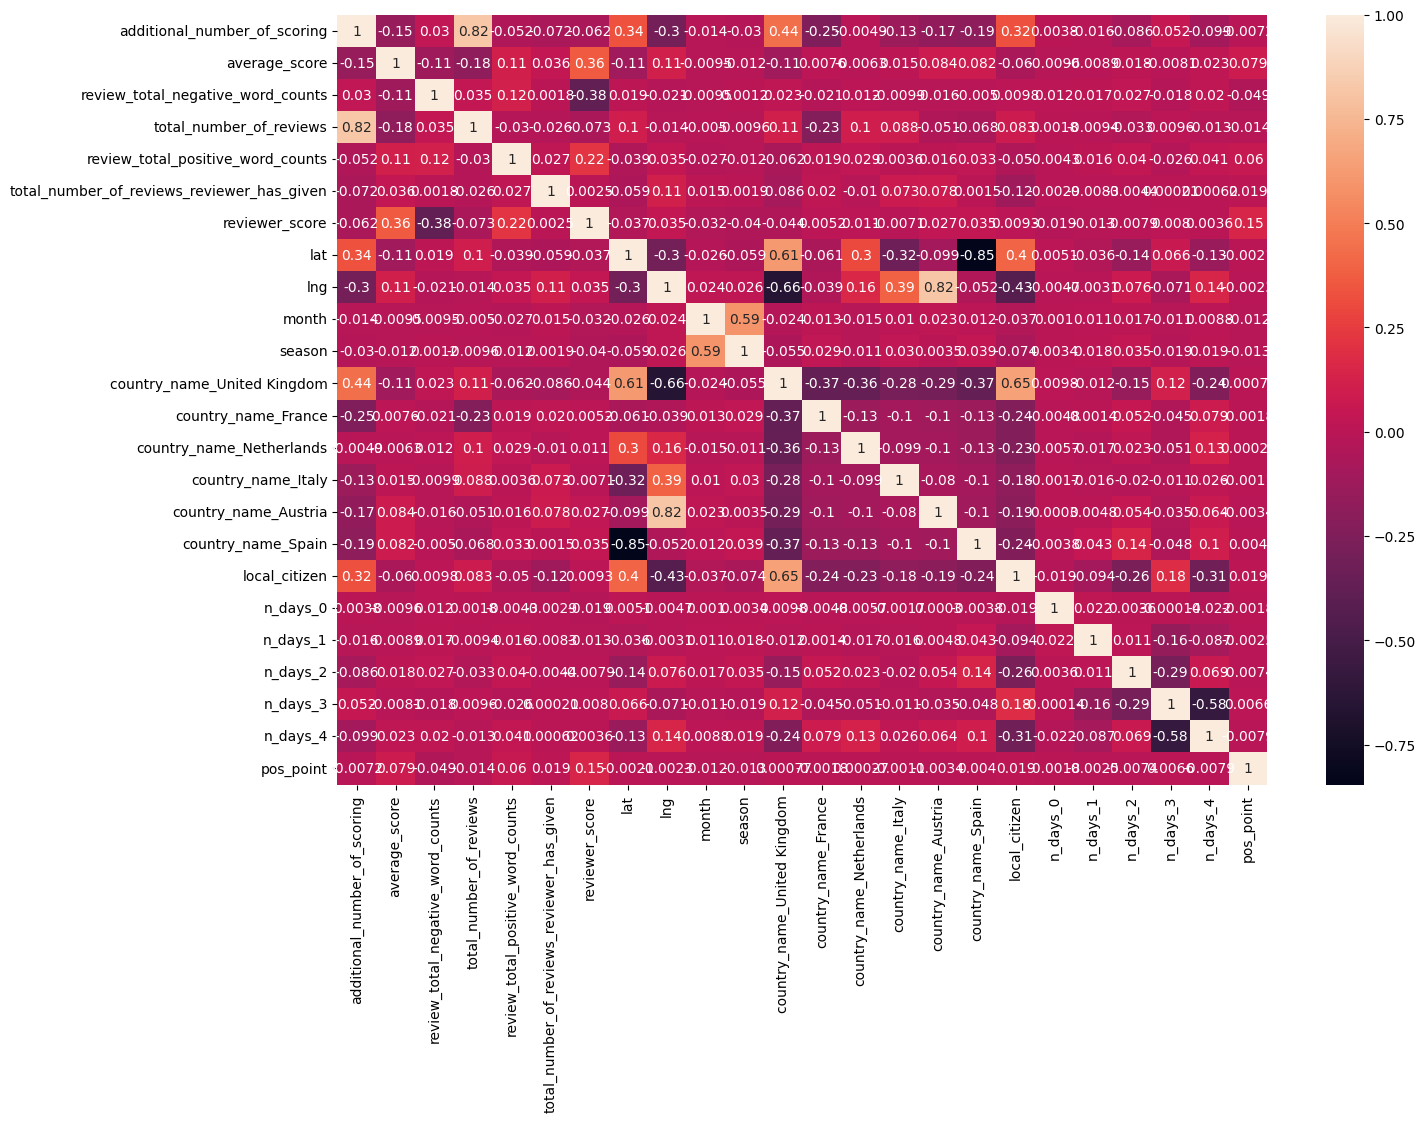

In [505]:
plt.rcParams['figure.figsize'] = (15,10)

sns.heatmap(hotels.corr(), annot=True)

In [506]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

3. Очистка датасета от неинформативных и вспомогательных признаков

In [507]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace = True)
#Для конкретной задачигеографические координаты не несут информации
hotels.drop('lng', axis = 1, inplace = True)
hotels.drop('lat', axis = 1, inplace = True)
hotels.drop('month', axis = 1, inplace = True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   season                                      386803 non-null  int64  
 8   country_name_United Kingdom                 386803 non-null  int64  
 9   country_name_France                         386803 non-null  int64  
 

<AxesSubplot: >

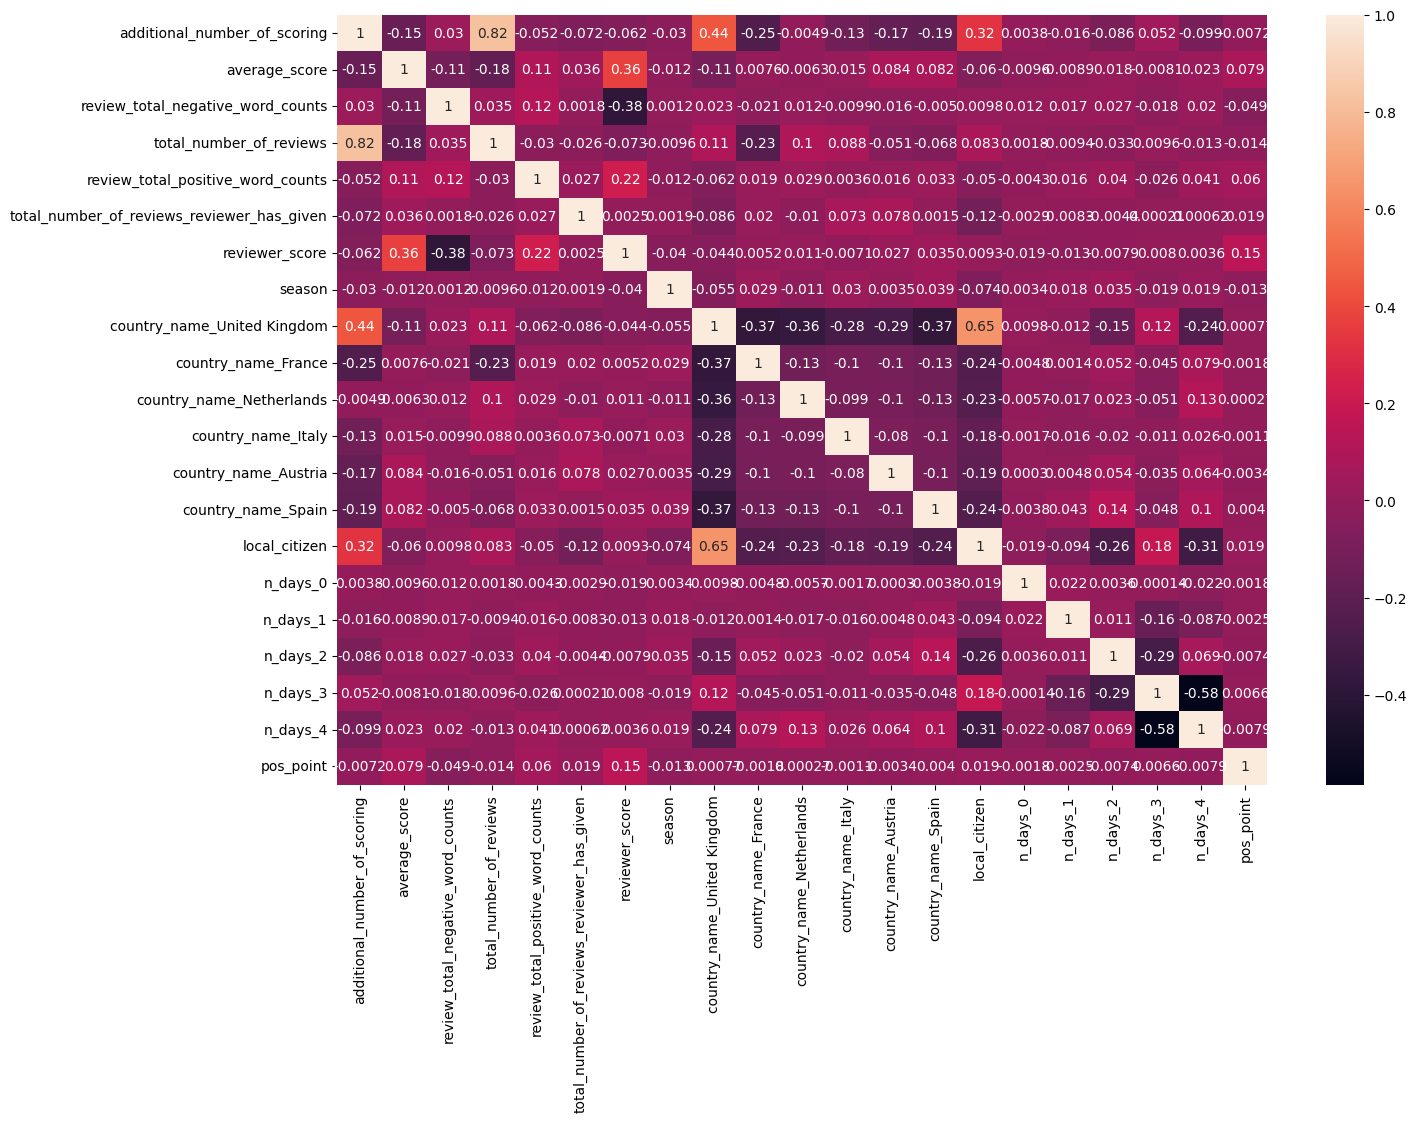

In [508]:
plt.rcParams['figure.figsize'] = (15,10)

sns.heatmap(hotels.corr(), annot=True)

Удаляем столбцы с высокой корелляцией.

In [509]:
hotels.drop('additional_number_of_scoring', axis = 1)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,season,country_name_United Kingdom,country_name_France,country_name_Netherlands,country_name_Italy,country_name_Austria,country_name_Spain,local_citizen,n_days_0,n_days_1,n_days_2,n_days_3,n_days_4,pos_point
0,8.4,3,1994,4,7,10.0,1,1,0,0,0,0,0,1,0,0,0,0,1,0
1,8.3,3,1361,2,14,6.3,1,1,0,0,0,0,0,1,0,0,0,1,0,0
2,8.9,6,406,0,14,7.5,4,0,1,0,0,0,0,0,0,0,0,1,1,0
3,7.5,0,607,11,8,10.0,4,0,1,0,0,0,0,0,0,0,0,1,0,0
4,8.5,4,7586,20,10,9.6,2,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9.0,0,617,10,10,8.8,2,1,0,0,0,0,0,0,0,0,0,0,1,0
386799,8.4,0,3224,93,1,9.2,1,0,0,0,0,1,0,0,0,0,1,0,1,0
386800,6.8,12,2751,9,21,8.3,1,1,0,0,0,0,0,0,0,0,0,1,0,0
386801,8.1,0,1567,6,28,9.2,2,1,0,0,0,0,0,0,0,0,0,0,1,0


4. Обучение модели и получение предсказания

In [510]:
y = hotels.reviewer_score.values
X = hotels.drop(['reviewer_score'], axis=1)
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290102 entries, 22852 to 121958
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                290102 non-null  int64  
 1   average_score                               290102 non-null  float64
 2   review_total_negative_word_counts           290102 non-null  int64  
 3   total_number_of_reviews                     290102 non-null  int64  
 4   review_total_positive_word_counts           290102 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  290102 non-null  int64  
 6   season                                      290102 non-null  int64  
 7   country_name_United Kingdom                 290102 non-null  int64  
 8   country_name_France                         290102 non-null  int64  
 9   country_name_Netherlands                    290102 non-null  int64

In [511]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [512]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13707309309171772
